# Prevendo a nota da prova final de alunos

## Introdução

Durante os últimos anos, com a vinda da pandemia e a mudança do ensino presencial para a modalidade online/à distância, houve [uma queda notável](https://www.nytimes.com/2021/06/23/us/failing-grades-covid.html) nas notas dos alunos que tiveram que se adaptar para um novo modelo de ensino. Sendo causada a queda pelo [efeito psicológico da pandemia](https://namica.org/blog/impact-on-the-mental-health-of-students-during-covid-19/), ou pela falta de ambientes de ensino apropriados para o estudo remoto, ou por qualquer outro fator, isto foi a realidade em que muitos dos estudantes da atualidade viveram, e agora com a volta do ensino presencial aos poucos, nos interessamos em descobrir quanto as circunstâncias de ensino podem afetar a nota dos alunos.

Buscamos por um dataset que nos permitisse tentar prever a nota de alunos com base não só no desempenho escolar, mas também nas qualidades da escola onde estudam, porque uma das causas principais para esse efeito que foi citada em [reportagens sobre o tema](https://www.washingtonpost.com/education/2020/12/06/more-students-than-ever-got-fs-first-term-2020-21-school-year-are-a-f-grades-fair-pandemic/) foi a mudança de um ambiente escolar para um ambiente residencial, e como isto foi algo que também nos afetou muito como estudantes, nos motivamos para tentar descobrir se o ambiente de ensino do estudante consegue ser tão importante assim no desempenho.

## Descrição do Dataset

Encontramos um dataset que nos pareceu interessante para tentar prever a nota depois da prova final de um aluno aleatório com base nas características da escola dele, e da nota dele antes da prova, este que está disponível [aqui](https://www.kaggle.com/kwadwoofosu/predict-test-scores-of-students). Primeiro, vamos descrever as variáveis encontradas no dataset. Entre colchetes idenfiticamos o tipo da variável, e as variáveis categóricas que tenham apenas 2 categorias foram chamadas de binárias pois a biblioteca utilizada para modelar o problema faz essa distinção.
* school: código representando o nome da escola; [Qualitativa]
* school_setting: o meio onde a escola se encontra (Rural, Suburban, Urban); [Categórica]
* school_type: se a escola é pública ou privada; [Binária]
* classroom: código representando o tipo de sala de aula da escola; [Qualitativa]
* teaching_method: o método de ensino empregado pela escola (Standard, Experimental); [Binária]
* n_student: número de alunos em cada sala; [Numérica e contínua]
* student_id: código representando a matrícula de um aluno na sua escola; [Qualitativa]
* gender: o gênero com o qual o aluno se identifica (Female, Male); [Binária]
* lunch: se o aluno faz parte do programa de distribuição de merenda; [Binária]
* pretest: a nota do aluno antes da prova final; [Numérica e contínua]
* posttest: a nota do aluno depois da prova final; [Numérica e contínua]

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import scipy.stats as stats
from math import sqrt
from sklearn.model_selection import KFold

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


Abaixo, as primeiras linhas do dataset:

In [2]:
raw_data = pd.read_csv("test_scores.csv",)
raw_data.head()

,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest
0,ANKYI,Urban,Non-public,6OL,Standard,20.0,2FHT3,Female,Does not qualify,62.0,72.0
1,ANKYI,Urban,Non-public,6OL,Standard,20.0,3JIVH,Female,Does not qualify,66.0,79.0
2,ANKYI,Urban,Non-public,6OL,Standard,20.0,3XOWE,Male,Does not qualify,64.0,76.0
3,ANKYI,Urban,Non-public,6OL,Standard,20.0,556O0,Female,Does not qualify,61.0,77.0
4,ANKYI,Urban,Non-public,6OL,Standard,20.0,74LOE,Male,Does not qualify,64.0,76.0


Removemos algumas colunas que não auxiliariam a obter algum resultado, conforme as justificativas.
* school: não contribui na análise e foi retirada pela possibilidade de gerar ruído no modelo;
* classroom: não foi fornecida ou encontrada qualquer descrição para o significado dos tipos de sala de aula, então a retiramos para evitar possíveis ruídos no modelo;
* student_id: assim como a variável school, essa coluna não contribui na análise de maneira significativa mas poderia gerar muito ruído caso a mantivéssemos.

Em seguida, as primeiras linhas novamente, sem as colunas supracitadas:

In [3]:
#Pegando apenas variaveis relevantes
f_data = raw_data.loc[:,~raw_data.columns.isin({"school","classroom","student_id"})].copy()
f_data.head()

,school_setting,school_type,teaching_method,n_student,gender,lunch,pretest,posttest
0,Urban,Non-public,Standard,20.0,Female,Does not qualify,62.0,72.0
1,Urban,Non-public,Standard,20.0,Female,Does not qualify,66.0,79.0
2,Urban,Non-public,Standard,20.0,Male,Does not qualify,64.0,76.0
3,Urban,Non-public,Standard,20.0,Female,Does not qualify,61.0,77.0
4,Urban,Non-public,Standard,20.0,Male,Does not qualify,64.0,76.0


Como mencionado antes, escolhemos a variável posttest como a nossa variável target.

In [4]:
target ="posttest"
features = [col for col in f_data.columns if col != target]

As variáveis categóricas (school_setting, school_type, teaching_method, gender, lunch) do dataset estão definidas como objeto e não categoria, então fizemos essa mudança na célula abaixo.

In [5]:
#transformando variaveis nao numericas em categoricas
for col in f_data.columns:
    if (f_data[col].dtype == "object"):
        f_data[col] = f_data[col].astype('category')

## Análise Exploratória

### Variável Target
Analizamos dados sobre a distribuição das notas finais dos alunos, afim de ter uma referência das notas do nosso sample, e podermos obter resultados mais conclusivos na análise futura das variáveis feature.

Optamos por fazer isso de duas maneiras: descrevendo os dados numericamente, e fazendo dois gráficos que facilitam a visualização destes dados: um boxplot, e um histograma. 

In [6]:
f_data.posttest.describe().to_frame()

,posttest
count,2133.000000
mean,67.102203
std,13.986789
min,32.000000
25%,56.000000
50%,68.000000
75%,77.000000
max,100.000000


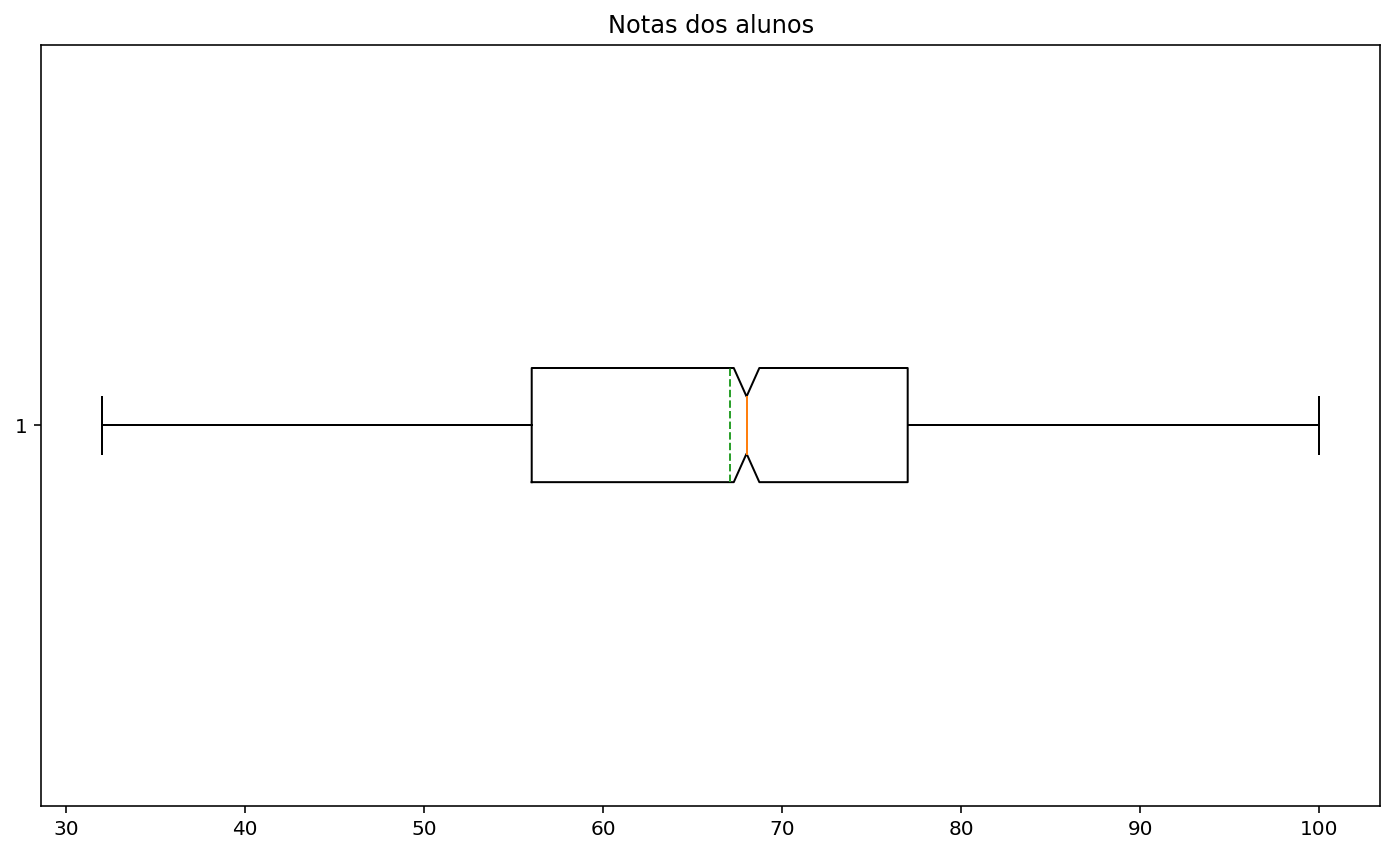

In [7]:
plt.title("Notas dos alunos")
plt.boxplot(f_data.posttest, vert = False, meanline = True, showcaps = True, showbox = True, showfliers = True, showmeans = True, notch = True)
plt.show()

Ao ver o boxplot da variável target, conseguimos tirar algumas conclusões iniciais sobre a coluna posttest com mais facilidade do que teríamos tendo só a descrição numérica. Por exemplo, vemos como é a distribuição populacional do sample conforme os quartis: há mais alunos com notas acima da média do que abaixo, o que condiz com a expectativa de que mais alunos passam de ano na escola do que não. 

Mais do que isso, temos uma comparação entre a média (linha verde pontilhada) e a mediana (linha contínua laranja) dos dados, e vemos que por mais que os valores pareçam similares numericamente, há uma distância entre elas no boxplot que sugira que há uma concentração de alunos em torno da média dos dados, por mais que a metade superior dos dados apresente maior densidade.

In [8]:
g_bins = range(30,101,5)

In [9]:
def color_red(ax,n): #Colore parte do Histograma de vermelho
    for i in range(len(ax.patches)):
        if i < n:
            ax.patches[i].set_facecolor('r')

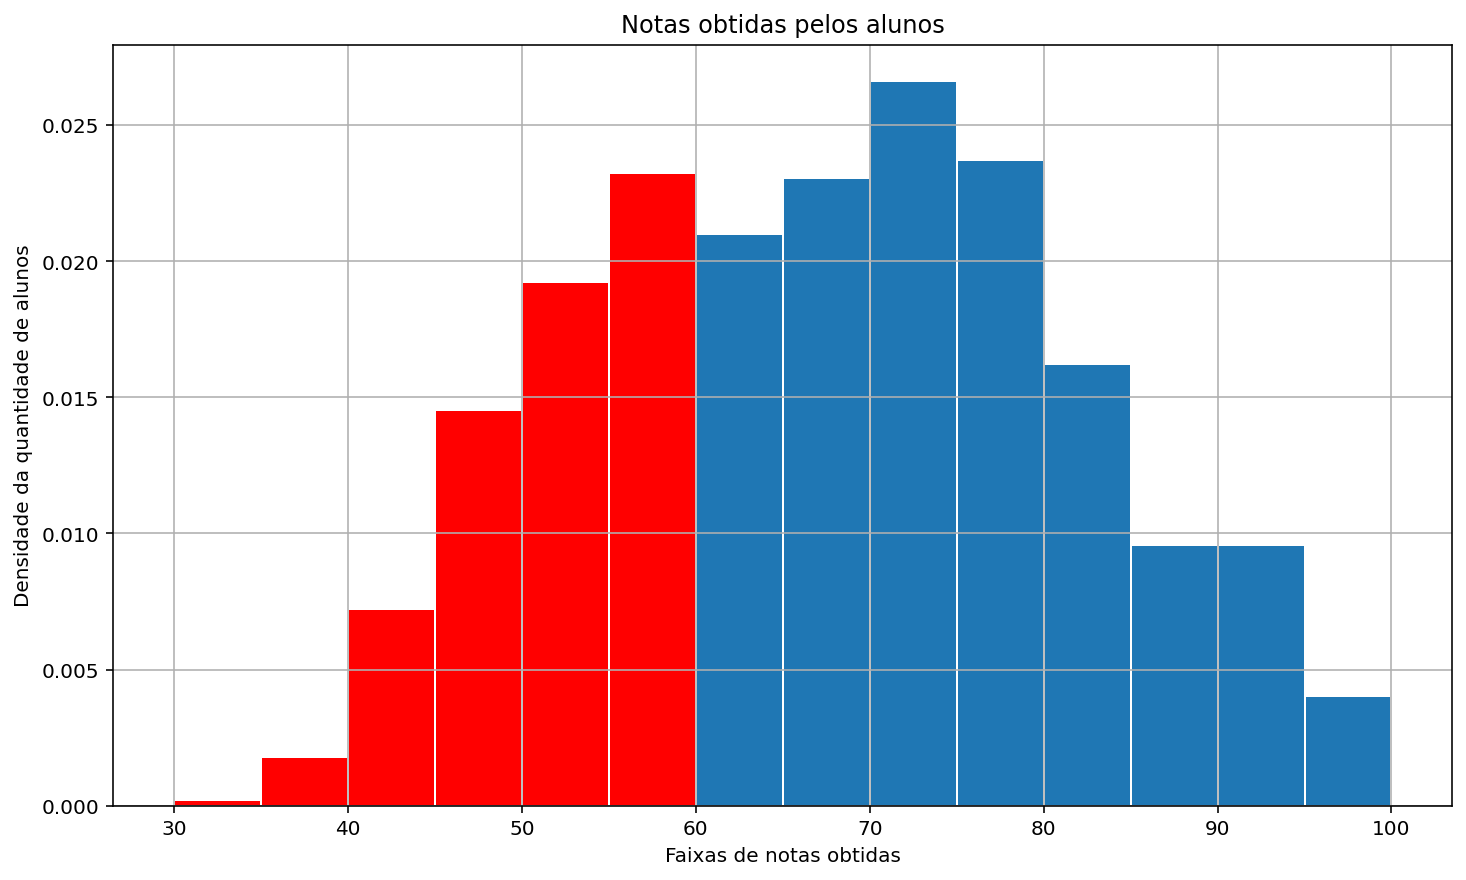

In [10]:
ax = f_data.posttest.hist(edgecolor = 'white',bins = g_bins, density = True)

color_red(ax,6)

plt.title('Notas obtidas pelos alunos')
plt.ylabel('Densidade da quantidade de alunos')
plt.xlabel('Faixas de notas obtidas')
plt.show()

Também foi realizada a confecção de um histograma, onde foi colorido de vermelho as barras que representam alunos que tenham uma nota abaixo da média (60), e de azul as notas que significariam uma aprovação no fim do ano.

Foi considerado interessante fazer um boxplot e um histograma porque enquanto eles servem propósitos similares, eles dispõem a informação de maneiras que permitem diferentes conclusões a serem tiradas. O histograma diz onde fica a maior quantidade de alunos em um certo intervalo de notas - entre 70 e 75 pontos -, e permite avaliar como os dados estão distribuidos. O boxplot, no entanto, dá uma visualização mais geral do dataset, respondendo perguntas como: onde ficam os quartis em relação à média e a mediana? Elas são iguais? Como as notas estão distribuidas em relação à média e mediana?

### Variáveis Feature

Além de facilitar a visualização dos conteúdos destas variáveis como fizemos com a variável target, também tentamos averiguar se existe alguma correlação entre elas, ou alguma outra variável que deveríamos retirar para evitar ruídos.

Primeiro, fizemos histogramas com base nas categorias binárias das notas dos alunos, novamente marcando as notas abaixo da média em vermelho para facilitar a visualização.

['school_type', 'teaching_method', 'gender', 'lunch']


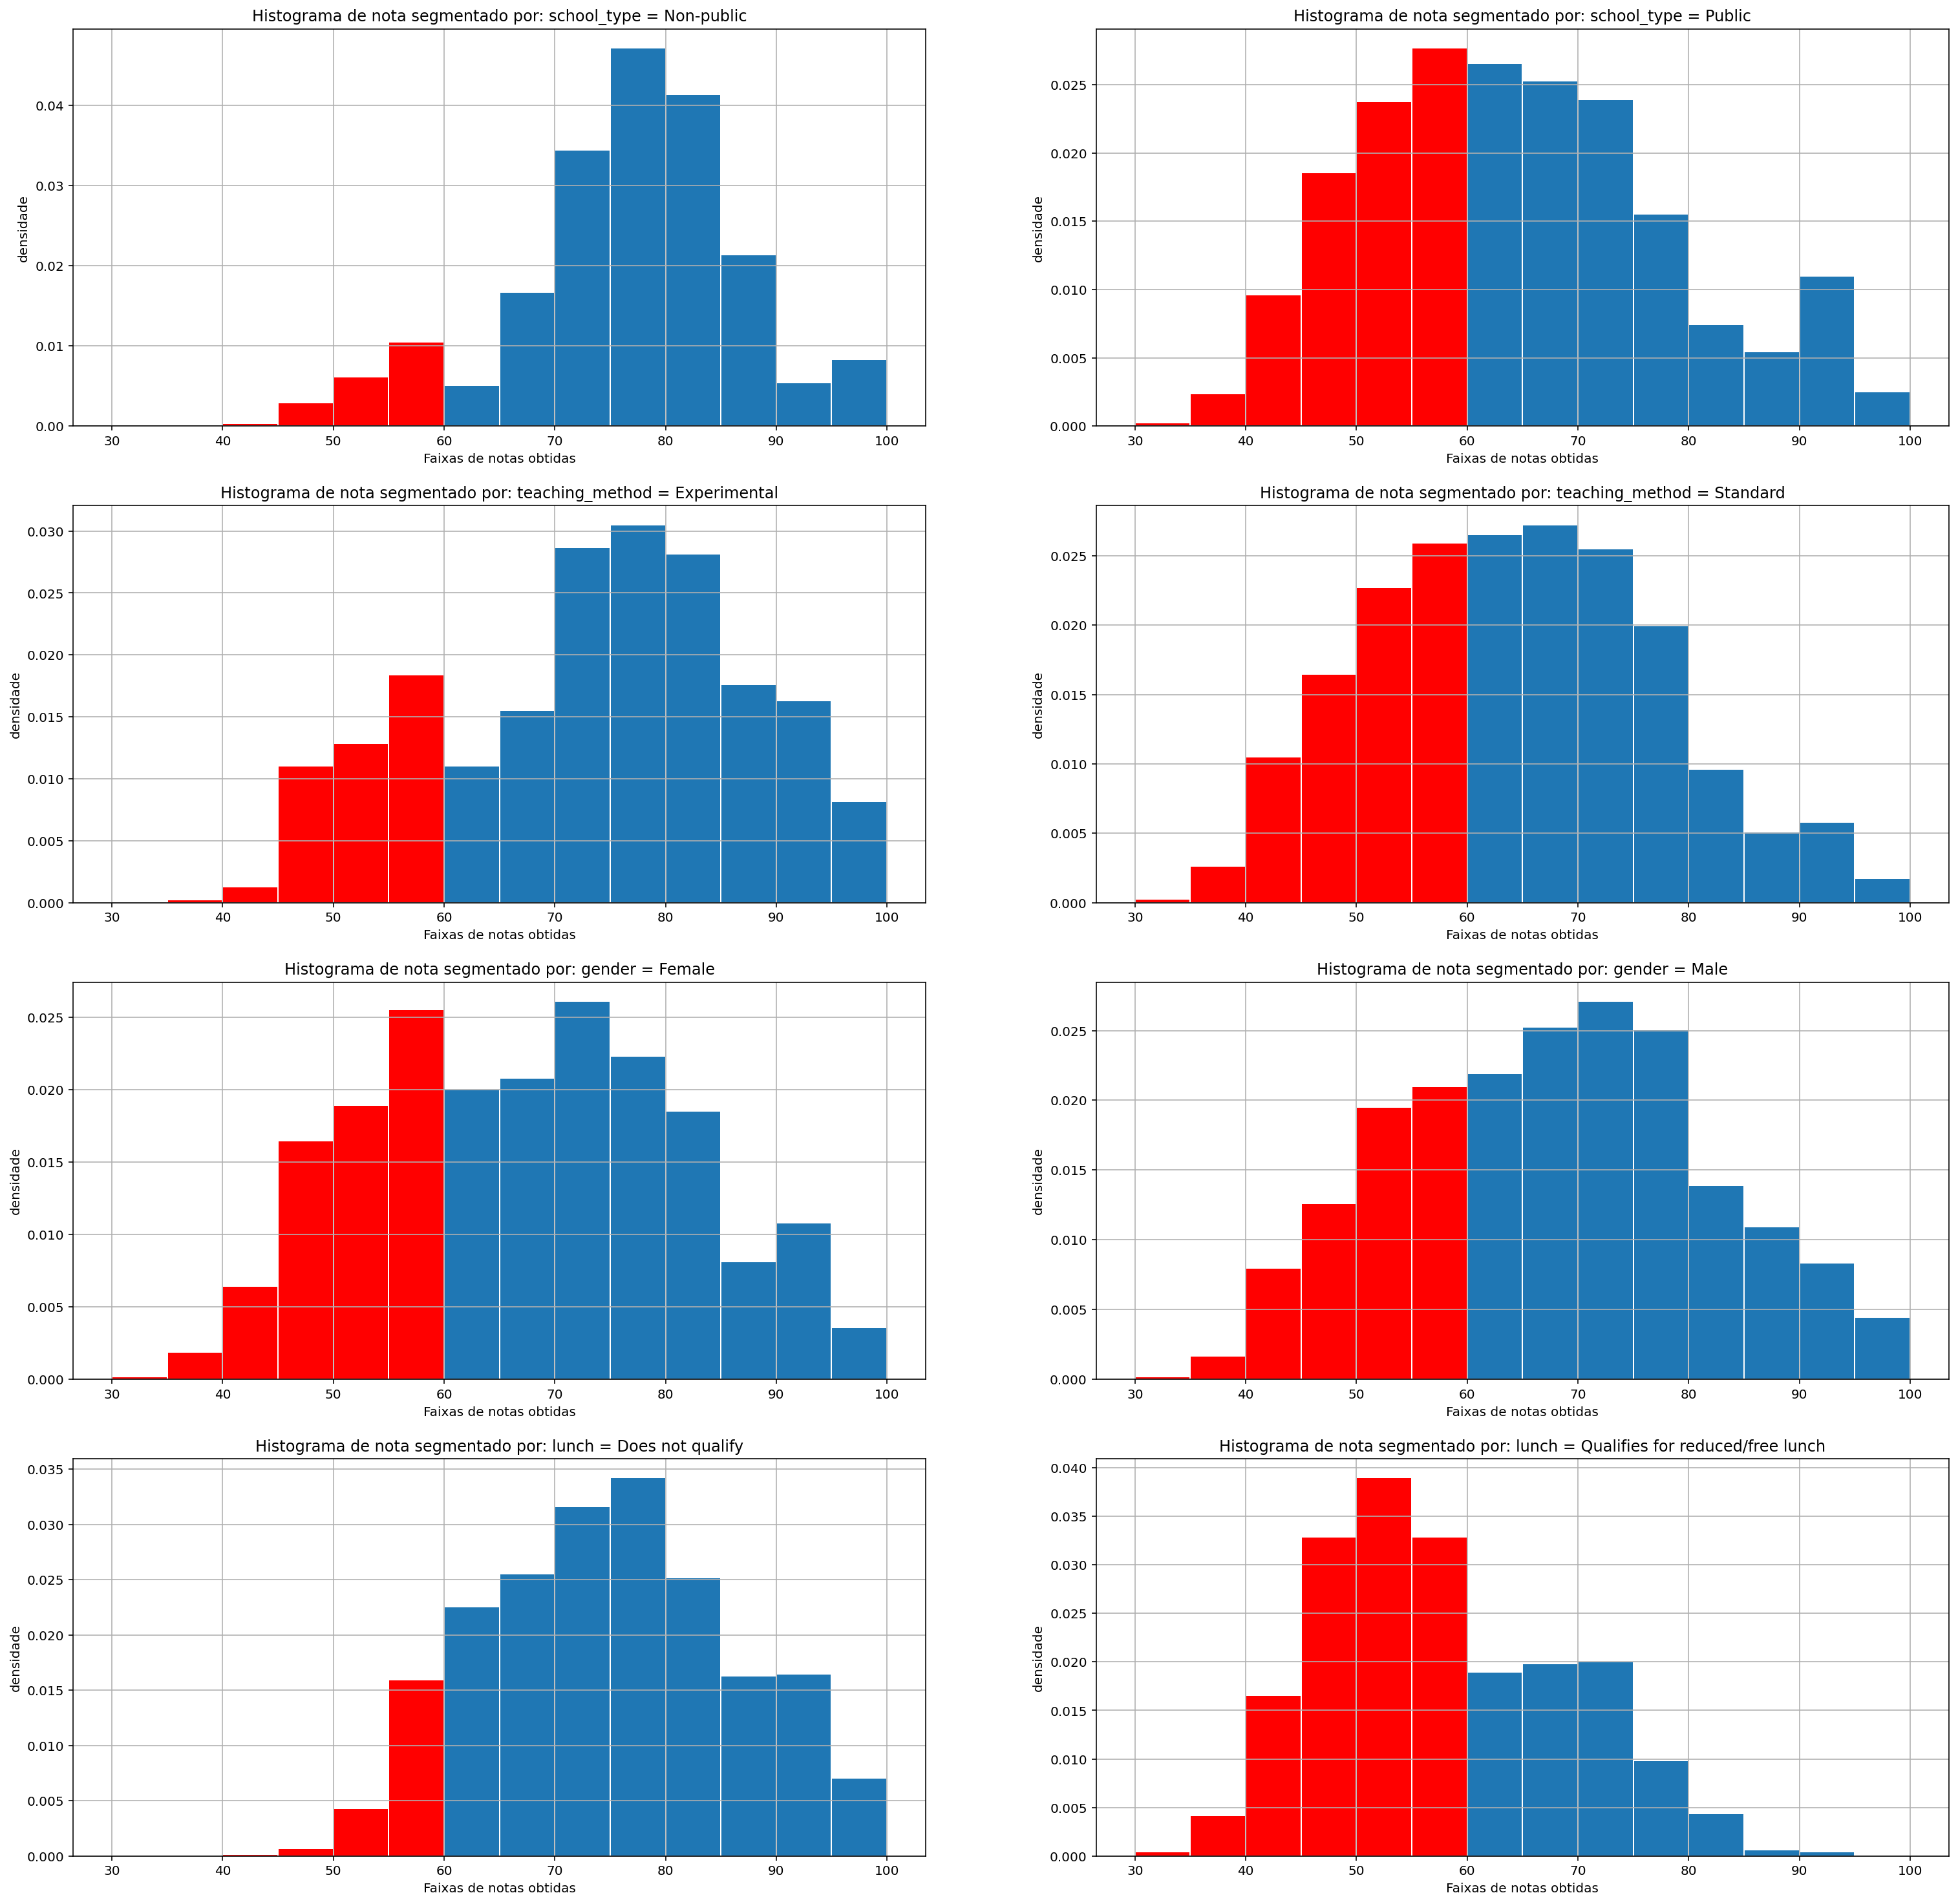

In [11]:
#Automaticamente gera Histogrmas do target segmentados pelas variaveis binarias

plt.figure(figsize =(26,26))
binary_cols = [col for col in f_data.columns if str(f_data[col].dtype) == 'category' and len(f_data[col].cat.categories)==2 ]
c = 1
print(binary_cols)

for j, col in enumerate(binary_cols):
    cats = f_data[col].cat.categories
    for i in range(len(cats)):
        plt.subplot(len(binary_cols),2,c)
        plt.title(f'Histograma de nota segmentado por: {col} = {cats[i]}')
        plt.xlabel('Faixas de notas obtidas')
        plt.ylabel('densidade')
        ax = f_data.loc[f_data[col] == cats[i],'posttest'].hist(edgecolor = 'white',bins = g_bins,density = True)
        color_red(ax,6)
        c+=1
plt.show()

Analisando os histogramas é possível notar que a variável gênero parece não influenciar muito o target. A distribuição do target para ambos gêneros é simétrica e a densidade das faixas nas extremidades parece ser semelhante apesar de a densidade das faixas mais próximos da media ser um pouco diferente. Para se ter informações mais concretas pode-se fazer as medidas resumo adequadas.

In [50]:
df = f_data.groupby('gender').describe().posttest


styler = df.style.set_caption(title).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '15px'),
        ('font-weight', 'bold'),
        ('text-align', 'center')
    ]
}])
styler.set_caption('Resumo Posttest segmentado por genero')

display(styler)

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
Female,1056.000000,67.004735,14.139018,32.000000,56.000000,68.000000,78.000000,100.000000
Male,1077.000000,67.197772,13.841807,34.000000,57.000000,68.000000,77.000000,100.000000


Analisando os valores acima nota-se que a média de nota para ambos gêneros é muito próxima assim como o valor de todos quartis. Por isso decidiu-se remover a variável gender do modelo.

In [52]:
f_data.drop(columns='gender')

,school_setting,school_type,teaching_method,n_student,lunch,pretest,posttest
0,Urban,Non-public,Standard,20.0,Does not qualify,62.0,72.0
1,Urban,Non-public,Standard,20.0,Does not qualify,66.0,79.0
2,Urban,Non-public,Standard,20.0,Does not qualify,64.0,76.0
3,Urban,Non-public,Standard,20.0,Does not qualify,61.0,77.0
4,Urban,Non-public,Standard,20.0,Does not qualify,64.0,76.0
...,...,...,...,...,...,...,...
2128,Urban,Public,Standard,30.0,Does not qualify,39.0,55.0
2129,Urban,Public,Standard,30.0,Qualifies for reduced/free lunch,38.0,46.0
2130,Urban,Public,Standard,30.0,Qualifies for reduced/free lunch,45.0,51.0
2131,Urban,Public,Standard,30.0,Qualifies for reduced/free lunch,46.0,53.0


Alguns destes histogramas, comparando a distribuição entre os dois valores das variáveis binárias, ressaltam um grande impacto na nota dos alunos, como por exemplo se a escola é pública ou particular. Uma quantidade quase irrelevante dos estudantes de escola particular tiram nota vermelha, enquanto uma quantidade extremamente significante dos alunos de escola pública fazem o mesmo. Isso indica que o tipo de escola onde o aluno estuda é um forte influenciador na nota.

É possível identificar uma discrepância similar ao outro caso na variável sobre o programa de distribuição de merenda, o que sugere que não é o tipo de escola que influencia mais no resultado que os estudantes apresentam, e sim a renda familiar dos alunos. Se um estudante estuda em escola pública e qualifica para o programa, há uma chance muito maior de que ele tenha nota abaixo da média do que um estudante de escola privada que não qualifique para o programa. Afim de tentar confirmar essa suspeita, tentamos traçar um gráfico conclusivo abaixo.

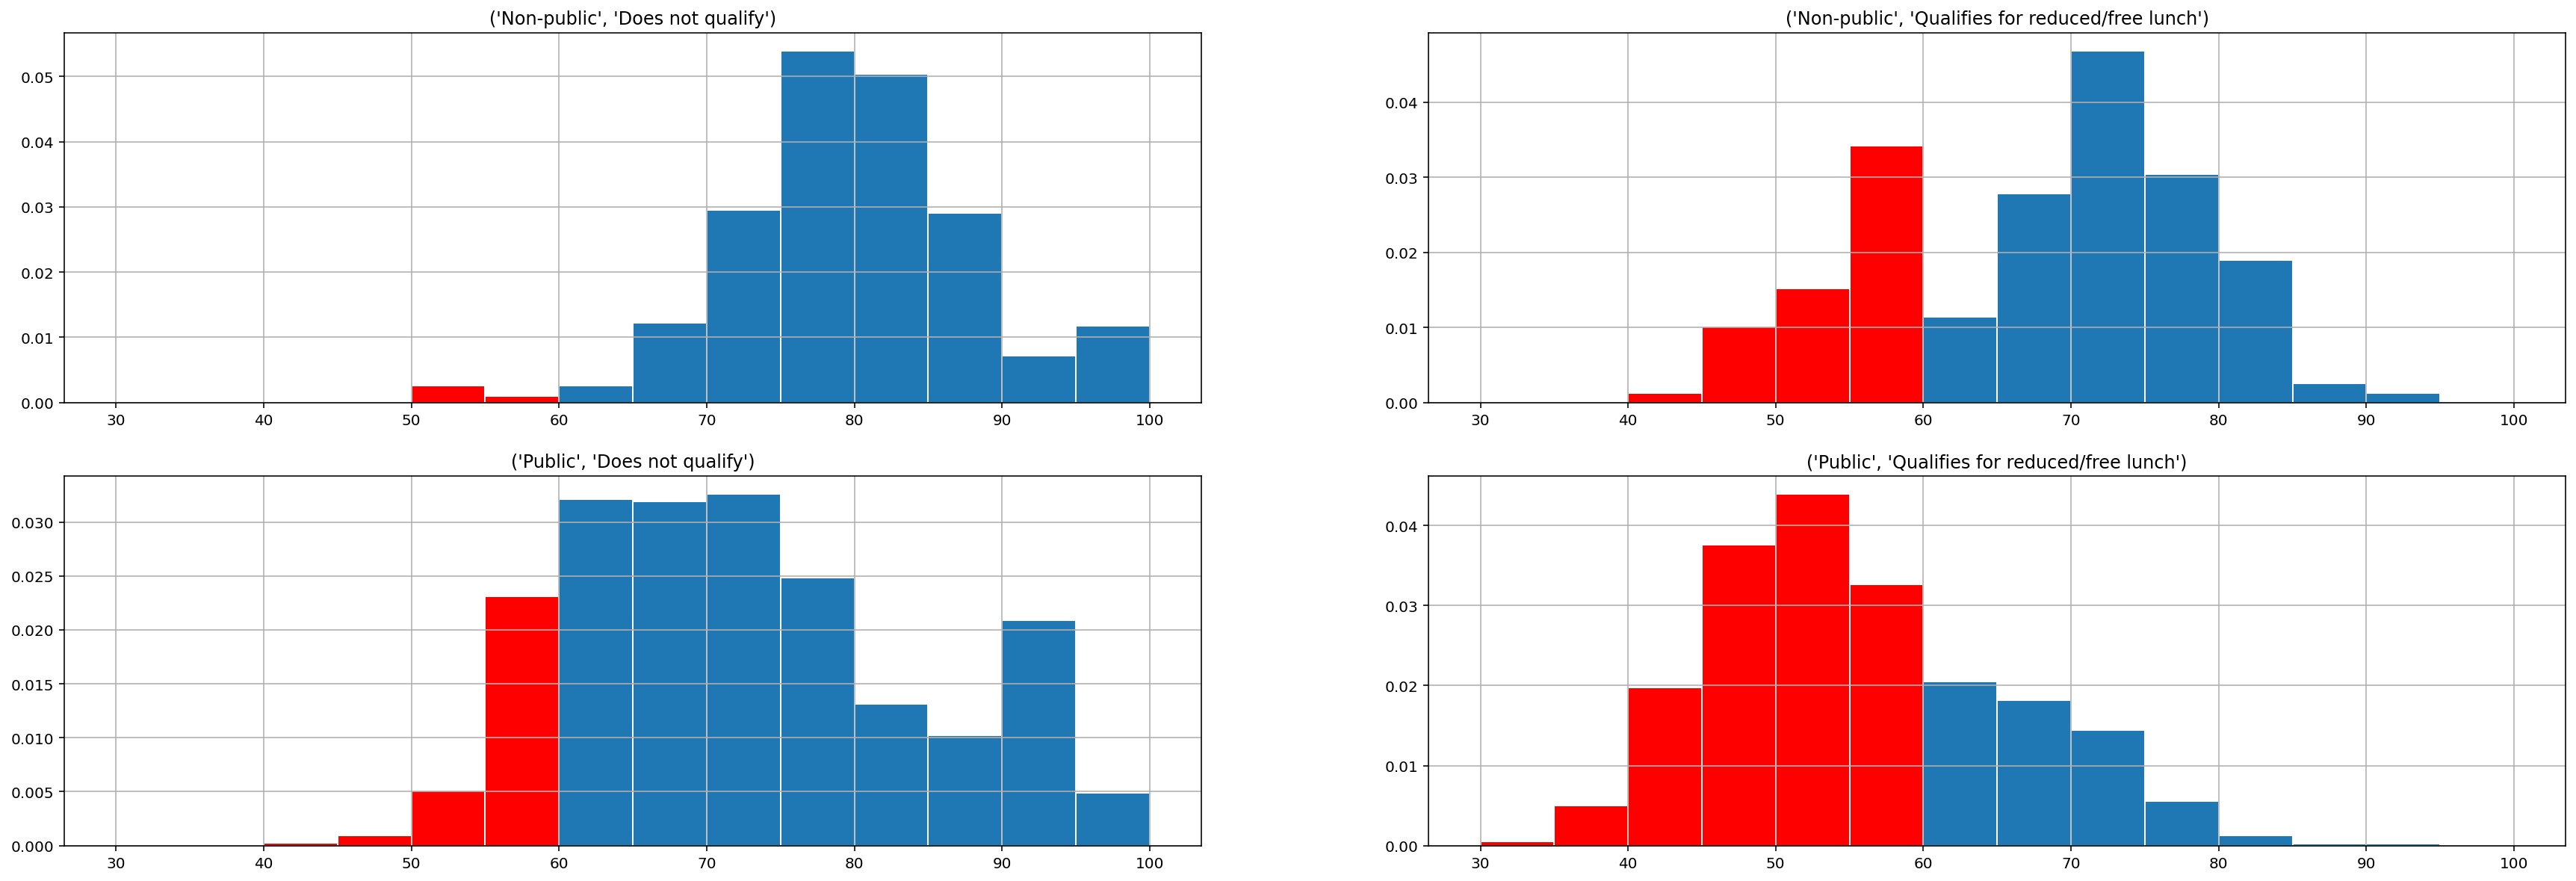

In [13]:
schools = f_data.school_type.cat.categories
lunch = f_data.lunch.cat.categories
inters = [(schools[i], lunch[j]) for i in range(2) for j in range(2)]
plt.figure(figsize=(30,10))
for i,inter in enumerate(inters):
    plt.subplot(221+i)
    plt.title(str(inter))
    ax = f_data.loc[(f_data.school_type == inter[0]) & (f_data.lunch == inter[1]),"posttest"].hist(edgecolor = 'white', bins = g_bins, density = True)
    color_red(ax,6)
plt.show()

Olhando os gráficos acima, é possível ver que há sim mais alunos que qualifiquem para o programa de merenda grátis que tenham nota vermelha, tanto nas escolas públicas quanto nas privadas.

Em comparação, os alunos que tiram notas azuis são muito menos padronizados entre as quatro categorias plotadas acima. Na sua maioria, as notas dos alunos de escola privada que não tiram nota vermelha tendem a circular entre 75 e 85 se não qualificam para o programa, e 70-75 se qualificam. Já nas escolas públicas, não existe um padrão identificável fora dizer que a maioria dos alunos que qualificam para o programa de merenda grátis representam a maioria das notas vermelhas das escolas. 

Para tentar investigar um pouco mais sobre a possibilidade, fizemos um crosstab entre os estudantes de cada tipo de escola e quem qualifica para o programa de merenda grátis, e chegamos à conclusão de que não podemos afirmar que qualificar ou não para o programa seja indicativo de notas mais ou menos altas. A maioria dos estudantes que qualificam para o programa se encontra em escolas públicas e é possível que seja este o fator determinante das notas, onde qualificar ou não para o programa seja menos relevante do que o tipo de escola onde estudam.

In [14]:
pd.crosstab(f_data.school_type,f_data.lunch,normalize='columns').round(3)*100

lunch,Does not qualify,Qualifies for reduced/free lunch
school_type,,
Non-public,32.3,17.2
Public,67.7,82.8


Foi decido também, explorar a possibilidade da renda ser um fator determinante forte das notas dos alunos, mas como não foi possível encontrar os requerimentos para qualificar para o programa de merenda grátis, não podemos afirmar que seja este o caso com certeza. Seria desejado entrar em mais detalhe nesta parte da análise exploratória em uma futura iteração do modelo onde houvesse mais informação sobre o programa de merenda grátis e a demografia das escolas públicas e particulares, porém para esta iteração é satisfatória em dizer que há forte indicação de que um dos fatores principais na nota dos alunos é realmente a renda.

In [15]:
binned_grades = pd.cut(f_data.posttest, bins=g_bins)
(pd.crosstab(binned_grades,f_data.school_setting,normalize="columns")*100).round(1)

school_setting,Rural,Suburban,Urban
posttest,,,
"(30, 35]",0.0,0.0,0.3
"(35, 40]",3.1,0.0,1.2
"(40, 45]",8.0,0.0,5.8
"(45, 50]",3.9,0.6,15.5
"(50, 55]",9.2,2.5,16.9
"(55, 60]",15.1,6.0,13.7
"(60, 65]",8.0,9.1,12.3
"(65, 70]",15.5,14.6,9.6
"(70, 75]",18.8,16.2,6.1


In [16]:
(pd.crosstab(binned_grades,pd.cut(f_data.n_student,bins=range(10,36,5)),normalize="columns")*100).round(1)

n_student,"(10, 15]","(15, 20]","(20, 25]","(25, 30]","(30, 35]"
posttest,,,,,
"(30, 35]",0.0,0.0,0.0,0.5,0.0
"(35, 40]",0.0,0.0,2.1,1.4,0.0
"(40, 45]",0.0,0.0,7.0,5.5,0.0
"(45, 50]",0.0,1.1,7.8,15.7,0.0
"(50, 55]",0.0,5.7,8.5,17.1,41.9
"(55, 60]",0.0,8.8,9.2,16.9,51.6
"(60, 65]",1.4,5.7,7.6,20.1,6.5
"(65, 70]",16.4,10.3,15.1,11.6,0.0
"(70, 75]",26.0,20.0,11.1,6.2,0.0


In [17]:
#Automaticamente transforma Variaveis categorigas e binarias em valores que podem ser usados pelo modelo
data = f_data.copy()
categories = dict()
for col in data.columns:
    if str(data[col].dtype) != "category": #Series numericas nao sao alteradas
        continue
    if len(cats := data[col].cat.categories) == 2: #Series com 2 categorias viram -1 e 1 (de acordo com recomendacao para variaveis binarias da documentacao do sklearn)
        categories[col] = {cats[0]:-1,cats[1]:1}
    else:                                           #Series com numero de categorias = n e n>2 viram 1,2,3...n (tambem de acordo com documentacao)
        categories[col] = {cats[i]:i for i in range(len(cats))}
    data[col] = data[col].apply(lambda x: categories[col][x])
print(categories)
data.head()

{'school_setting': {'Rural': 0, 'Suburban': 1, 'Urban': 2}, 'school_type': {'Non-public': -1, 'Public': 1}, 'teaching_method': {'Experimental': -1, 'Standard': 1}, 'gender': {'Female': -1, 'Male': 1}, 'lunch': {'Does not qualify': -1, 'Qualifies for reduced/free lunch': 1}}


,school_setting,school_type,teaching_method,n_student,gender,lunch,pretest,posttest
0,2,-1,1,20.0,-1,-1,62.0,72.0
1,2,-1,1,20.0,-1,-1,66.0,79.0
2,2,-1,1,20.0,1,-1,64.0,76.0
3,2,-1,1,20.0,-1,-1,61.0,77.0
4,2,-1,1,20.0,1,-1,64.0,76.0


## Aplicando modelos de Tomada de Decisão

A partir da análise exploratória feita, temos agora uma ideia muito mais consolidada dos fatores que podem influenciar a nota dos alunos, então partimos para testar alguns modelos de predição. Escolhemos os modelos Random Forest e Decision Tree para isso.

### Decision Tree


In [18]:
# Separa o df em train e test, com teste de 1/3
train, test =(data.iloc[:1400].copy(), data.iloc[1400:].copy())
tree = DecisionTreeRegressor()
forest = RandomForestRegressor()
print(train.drop(columns=["posttest"]).columns)
tree.fit(train.drop(columns=["posttest"]),train.posttest)
forest.fit(train.drop(columns=["posttest"]),train.posttest)
test["prediction_tree"] = tree.predict(test.drop(columns=["posttest"]))
test["prediction_forest"] = forest.predict(test.drop(columns=["posttest","prediction_tree"]))

test.head()

Index(['school_setting', 'school_type', 'teaching_method', 'n_student',
       'gender', 'lunch', 'pretest'],
      dtype='object')


,school_setting,school_type,teaching_method,n_student,gender,lunch,pretest,posttest,prediction_tree,prediction_forest
1400,1,1,1,22.0,-1,-1,63.0,75.0,73.0,70.510000
1401,1,1,1,22.0,1,-1,59.0,70.0,69.0,68.562500
1402,1,1,1,22.0,-1,-1,64.0,70.0,68.0,69.558000
1403,1,1,1,22.0,-1,-1,64.0,69.0,68.0,69.558000
1404,1,1,1,22.0,1,-1,60.0,70.0,67.0,67.823889


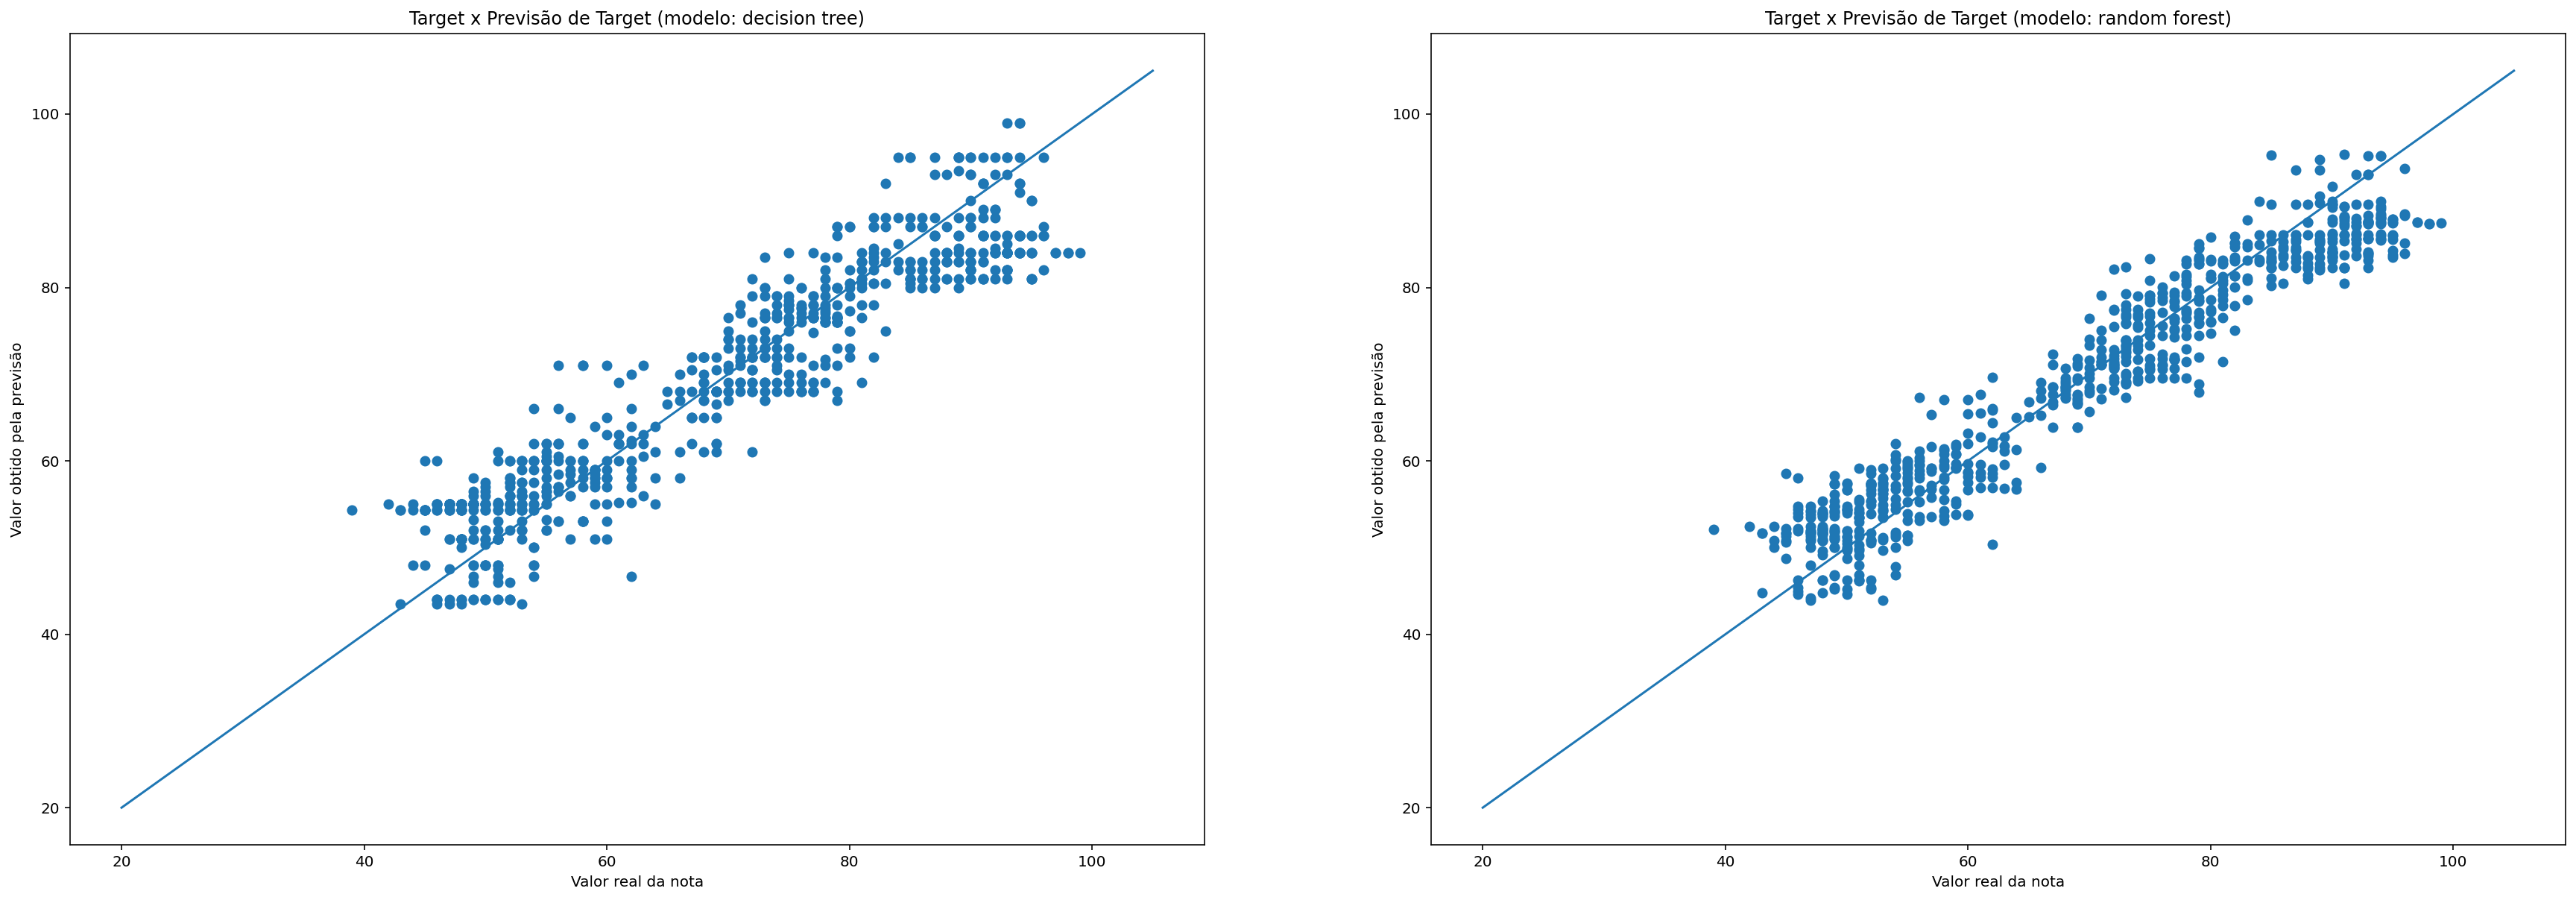

In [19]:
plt.figure(figsize=(30,10))

for title,col,i in zip(["(modelo: decision tree)","(modelo: random forest)"],[test.prediction_tree,test.prediction_forest],range(2)):
    plt.subplot(121+i)
    plt.title(f'Target x Previsão de Target {title}')
    plt.xlabel('Valor real da nota')
    plt.ylabel('Valor obtido pela previsão')
    plt.scatter(test.posttest,col)
    plt.plot([20,105],[20,105])

In [20]:
print(f'score tree: {tree.score(test.loc[:,features],test.loc[:,target])}')
print(f'score forest: {forest.score(test.loc[:,features],test.loc[:,target])}')

score tree: 0.8752661456898329
score forest: 0.9170175361818559


In [21]:
print(raw_data.school.to_list()[:200])

['ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'ANKYI', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 'CCAAW', 

In [22]:
features

['school_setting',
 'school_type',
 'teaching_method',
 'n_student',
 'gender',
 'lunch',
 'pretest']

In [23]:
r_data = data.sample(frac=1, random_state=13077, ignore_index=True)

# Separa o df em train e test, com teste de 1/3
r_train, r_test =(r_data.iloc[:1400].copy(), r_data.iloc[1400:].copy())
r_tree = DecisionTreeRegressor()
r_forest = RandomForestRegressor()
r_tree.fit(r_train.loc[:,features],r_train.posttest)
r_forest.fit(r_train.loc[:,features],r_train.posttest)
r_test["prediction_tree"] = r_tree.predict(r_test.loc[:,features])
r_test["prediction_forest"] = r_forest.predict(r_test.loc[:,features])

r_test.head()

,school_setting,school_type,teaching_method,n_student,gender,lunch,pretest,posttest,prediction_tree,prediction_forest
1400,0,-1,-1,18.0,-1,1,63.0,84.0,75.0,77.713333
1401,0,1,1,22.0,1,1,30.0,42.0,42.0,41.381333
1402,1,1,-1,23.0,1,-1,75.0,94.0,90.0,91.407643
1403,0,1,1,22.0,-1,1,42.0,56.0,50.0,52.024167
1404,1,-1,1,21.0,1,-1,76.0,85.0,80.0,82.012000


### Testando a performance dos modelos

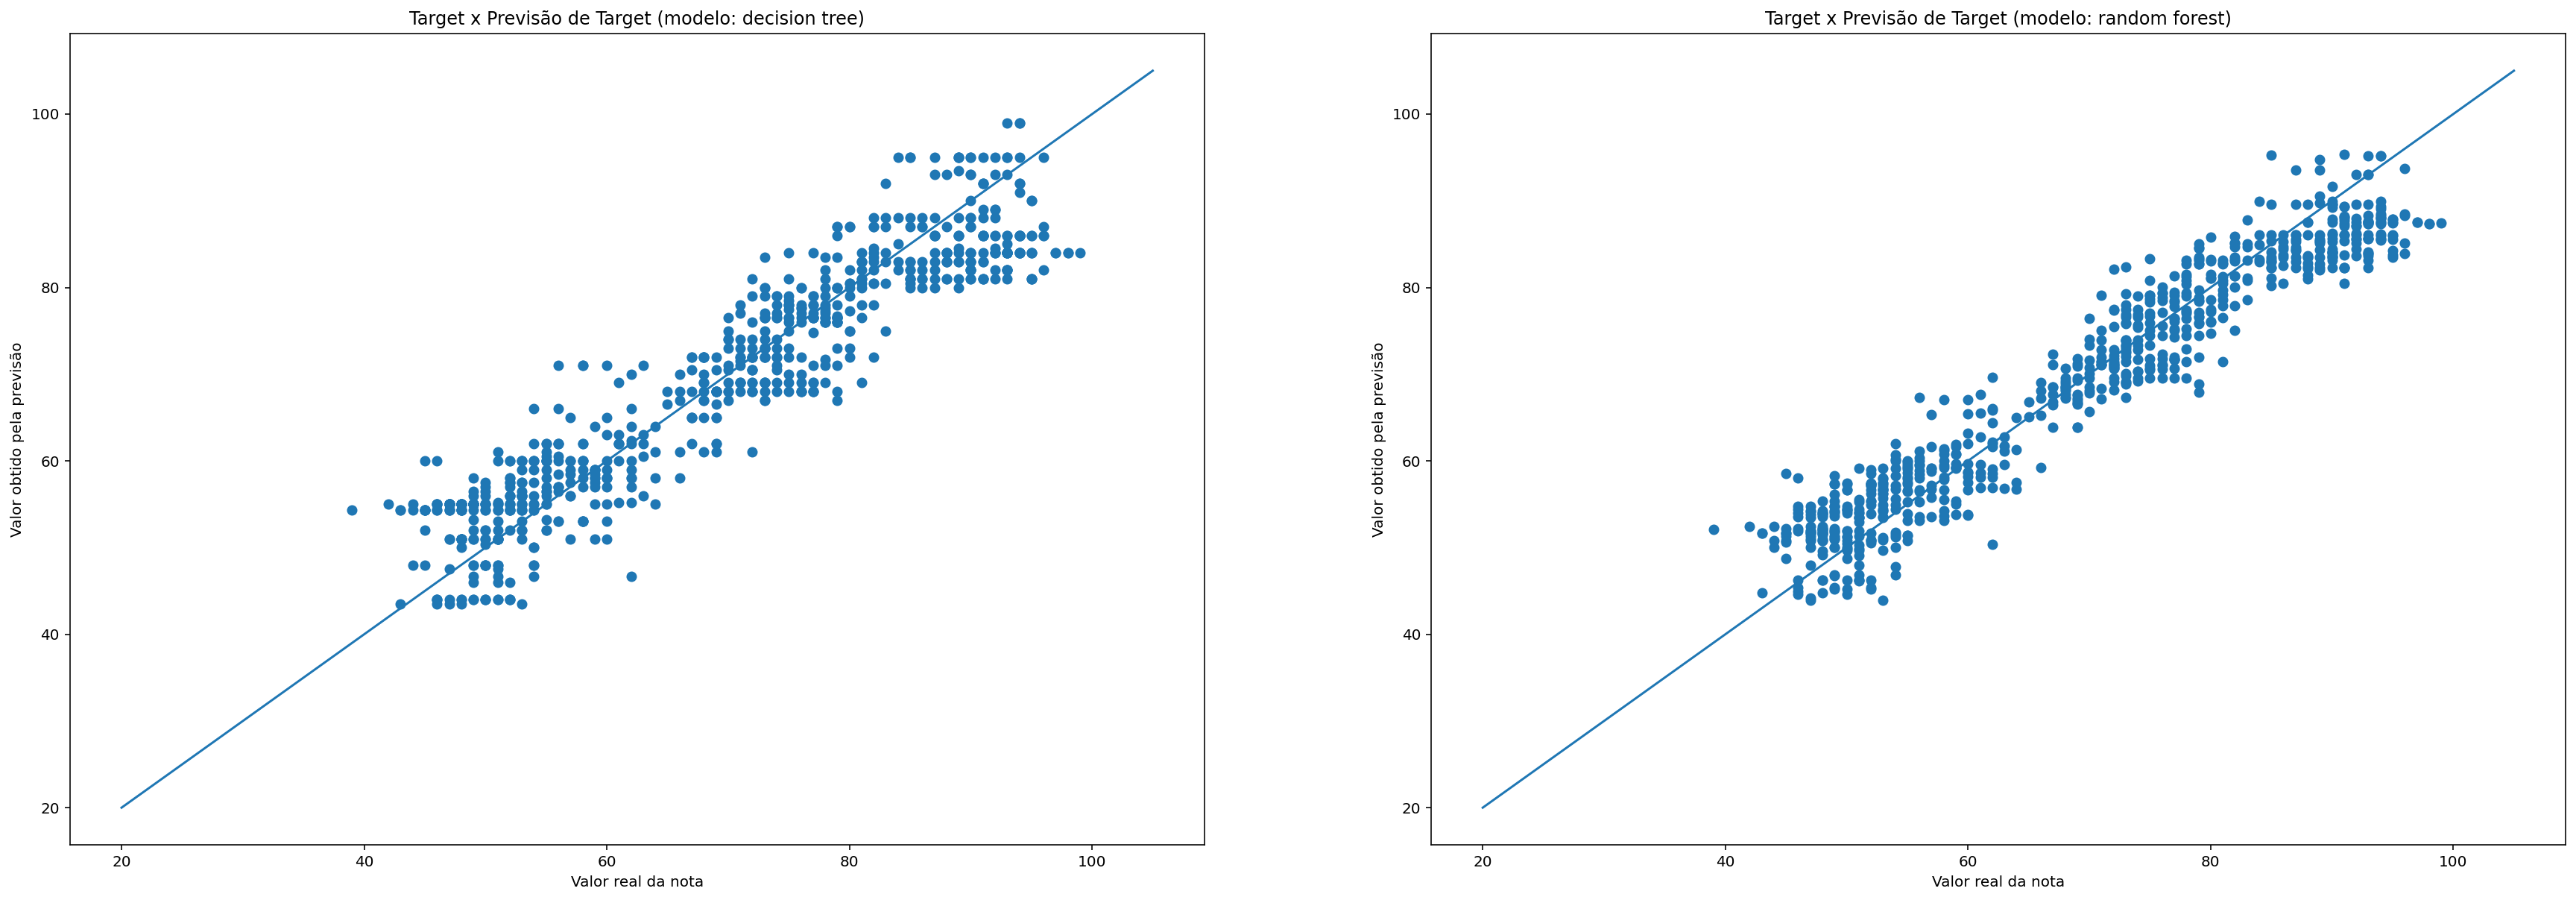

In [24]:
plt.figure(figsize=(30,10))

for title,col,i in zip(["(modelo: decision tree)","(modelo: random forest)"],[test.prediction_tree,test.prediction_forest],range(2)):
    plt.subplot(121+i)
    plt.title(f'Target x Previsão de Target {title}')
    plt.xlabel('Valor real da nota')
    plt.ylabel('Valor obtido pela previsão')
    plt.scatter(test.posttest,col)
    plt.plot([20,105],[20,105])

COMENTAR SOBRE A SIMILARIDADE VISUAL DOS GRÁFICOS E O QUE PODE INDICAR

### Obtendo o valor de R² para a previsão obtida

#### R² do Decision Tree

In [25]:
r_tree.score(test.loc[:,features],test.loc[:,target])

0.9738805983611681

#### R² do Random Forest

## Validação Cruzada

In [26]:
pd.DataFrame(cross_validate(r_tree,r_data.loc[:,features],r_data.loc[:,target],scoring=['r2','neg_root_mean_squared_error'],cv=KFold(n_splits=10)))

,fit_time,score_time,test_r2,test_neg_root_mean_squared_error
0,0.006749,0.002931,0.903326,-4.324653
1,0.005776,0.001982,0.944111,-3.555463
2,0.005038,0.001937,0.924247,-3.746950
3,0.005003,0.067067,0.912549,-3.969099
4,0.005387,0.001906,0.930376,-3.862045
5,0.004844,0.001890,0.921525,-4.068365
6,0.004639,0.001989,0.927501,-3.904852
7,0.004771,0.001864,0.928670,-3.746041
8,0.004872,0.001791,0.922200,-3.678200
9,0.004770,0.001936,0.907163,-3.845535


In [27]:
rmse = sqrt(mean_squared_error(test.loc[:,target], test.loc[:,"prediction_tree"]))
rmse

5.624064842346422